# 3. 멀티모달 RAG

PDF 분할 작업을 위해 `unstructured`를 사용합니다. `unstructured` 를 위해 다음과 도구의 설치가 필요합니다:

- `tesseract` : 광학 문자 인식(OCR)을 위해 사용
- `poppler` : PDF 렌더링 및 처리

[poppler 설치 방법](https://pdf2image.readthedocs.io/en/latest/installation.html)과 [tesseract 설치 방법](https://tesseract-ocr.github.io/tessdoc/Installation.html)을 참고하여 설치해주세요.

In [1]:
%%capture --no-stderr
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!sudo apt-get install poppler-utils

In [2]:
%%capture --no-stderr
! pip install -U langchain openai chromadb langchain-experimental langchain_openai nltk pydantic lxml matplotlib chromadb tiktoken
! pip install pillow == 11.1.0
! pip install "unstructured[all-docs]" == 0.17.2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("/content/.env")

True

In [5]:
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [6]:
# 파일 경로
fpath = '/content/drive/MyDrive/langchain-tutorial/Ch03. MultiModal RAG'
fname = "sample.pdf"

In [7]:
from unstructured.partition.pdf import partition_pdf
import os

# PDF에서 요소 추출
raw_pdf_elements = partition_pdf(
    filename=os.path.join(fpath, fname),
    extract_images_in_pdf=True,
    extract_image_block_types=["Image", "Table"],
    chunking_strategy="by_title",
    extract_image_block_output_dir=fpath,
)

In [8]:
# 텍스트, 테이블 추출
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))  # 테이블 요소 추가
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))  # 텍스트 요소 추가

In [9]:
tables[0]

'전년 대비(42주) 2023년 구분 2023년 증감 2024년 (1. 1.∼12. 31.) (%) (1. 1.∼10. 19.) (1. 1.∼10. 21.) 630 (100.0) 673 (100) 전체 663 (100.0) △5.0% 남자 성별 569 (84.5) 526 (83.5) 560 (84.5) △6.1% 1.0% 104 (15.5) 여자 103 (15.5) 104 (16.5) △60.0% 2 ( 0.3) 5 ( 0.7) 5 ( 0.8) 연령 0-9세 20 ( 3.2) 31 ( 4.6) 30 ( 4.5) 10-19세 △33.3% 20-29세 200 (30.2) 209 (33.2) 4.5% 201 (29.9) 30-39세 △18.2% 110 (16.6) 111 (16.5) 90 (14.3) △7.7% 104 (15.7) 96 (15.2) 107 (15.9) 40-49세 118 (17.5) 115 (17.3) △13.9% 50-59세 99 (15.7) 73 (11.6) 60-69세'

In [10]:
texts[0]

'42주차 (10.13.~10.19.)\n\nEe ee\n\n주차\n\n국내발생 해외유입\n\n전체'

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 프롬프트 설정
prompt_text = """당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다.
이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다.
표 또는 텍스트에 대한 간결한 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요. 표 또는 텍스트: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# 텍스트 요약 체인
model = ChatOpenAI(temperature=0, model="gpt-4o")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# 제공된 텍스트에 대해 요약을 할 경우
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
# 요약을 원치 않을 경우
# text_summaries = texts

# 제공된 테이블에 적용
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [12]:
table_summaries[0]

'2023년과 2024년의 성별 및 연령별 데이터 비교: 전체적으로 2023년 대비 2024년은 5.0% 감소. 남성은 6.1% 감소, 여성은 1.0% 증가. 연령별로는 0-9세가 60.0% 감소, 10-19세는 33.3% 감소, 20-29세는 4.5% 증가, 30-39세는 18.2% 감소, 40-49세는 7.7% 감소, 50-59세는 13.9% 감소, 60-69세는 15.7% 감소.'

In [13]:
text_summaries[0]

'42주차(10.13.~10.19.) 요약: 국내 발생 및 해외 유입 사례를 포함한 전체 통계.'

In [14]:
import base64


def encode_image(image_path) -> str:
    # 이미지 base64 인코딩
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


# 이미지의 base64 인코딩을 저장하는 리스트
img_base64_list = []

# 이미지를 읽어 base64 인코딩 후 저장
for img_file in sorted(os.listdir(fpath)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(fpath, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)

In [15]:
len(img_base64_list)

49

In [16]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


def image_summarize(img_base64: str) -> str:
    # 이미지 요약
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)
    prompt = """
    당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다.
    이 요약은 임베딩되어 원본 이미지를 검색하는 데 사용됩니다.
    이미지 검색에 최적화된 간결한 요약을 작성하세요.
    """
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content


# 이미지 요약을 저장하는 리스트
image_summaries = []

for img_base64 in img_base64_list:
    image_summary = image_summarize(img_base64)
    image_summaries.append(image_summary)


In [17]:
image_summaries[0]

'2024년 대한민국 질병관리청 말라리아 주간 소식지, 제42주차(10.13~10.19) 보고서.'

In [18]:
from langchain.retrievers import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# 분할한 텍스트들을 색인할 벡터 저장소
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# 원본문서 저장을 위한 저장소 선언
docstore = InMemoryStore()
id_key = "doc_id"

# 검색기
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

<ipython-input-18-b9ca233ad4d2>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag",


In [19]:
import uuid

# 원본 텍스트 데이터 저장
doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

# 원본 테이블 데이터 저장
table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

# 원본 이미지(base64) 데이터 저장
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [20]:
from langchain.schema.document import Document

# 텍스트 요약 벡터 저장
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)

# 테이블 요약 벡터 저장
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)

# 이미지 요약 벡터 저장

summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)

['bcb0a3cf-30ea-4ead-9ebf-438875eaf158',
 'e9529983-a1c5-4874-9512-3da4d4fb125c',
 'aa62c635-3de3-4e5b-b5ab-77c7a9188ed5',
 '92d26a8f-2724-42a7-8d8e-2ac5a95eb12f',
 'c95932f2-8ced-4fa0-a0cb-02de27739531',
 'db86bd3f-57b6-4ef3-800d-0323032a879a',
 '5c058666-ac7a-4423-bbeb-a6cdc01be96e',
 '14196b03-c6d0-4bb2-ac6a-019de6ac4503',
 '1dbd03df-b2e5-42c3-92ce-f89e5ec606a1',
 '8a67ab37-45fc-4e39-a765-f0a3e21a26db',
 'feca00f8-391c-4bb1-a488-dd3b57069c91',
 '14ceeb83-d130-4728-bb90-afa717135f8c',
 '0c0310bd-f99a-4a5a-a8e6-579e71f9b0e4',
 '9e2becec-8ffe-403e-8e69-29110297d201',
 'ec11c348-6e46-40b6-a055-8fbbce30e146',
 'd62df883-eda8-4683-b9e5-ad1e580a8db7',
 '4a74a391-3958-4b7a-a8f0-7de6abe57c4e',
 '68970d3c-2cfd-416d-91ad-81ed57c5e6f1',
 '1a9081fe-6616-4159-b094-20fbc458a0a3',
 'db13b8f8-f25a-4f9a-8776-3cfbbd30a889',
 'adf2bb83-d97c-41fb-b631-73a95f146f0c',
 'd96eff5c-52cc-4e66-a9b0-290ef8447e09',
 '907c283e-4b20-49ed-b04e-6d72ba4b3a3c',
 'e9dcdecd-1428-4f7c-becb-b8b0429c417c',
 '10efc400-f546-

In [21]:
docs = retriever.invoke(
    "말라리아 군집 사례는 어떤가요? "
)

In [22]:
len(docs)

4

In [23]:
from base64 import b64decode

def split_image_text_types(docs):
    # 이미지와 텍스트 데이터를 분리
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }

docs_by_type = split_image_text_types(docs)

In [24]:
len(docs_by_type["images"])

2

In [25]:
len(docs_by_type["texts"])

2

In [26]:
docs_by_type["images"][0][:100]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx'

In [27]:
docs_by_type["texts"]

['42주차 (10.13.~10.19.)\n\n3 말라리아 군집사례 현황\n\n* 군집사례 : 위험지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내, 환자 거주지 거리가 1Km 이내인 경우\n\n사례건수(환자수) 시·도 시군구 발생(군집사례건수) 4개 시도 46건(114명) 합계 ▸5명 군집(1) : 양천구, 강서구(1) 1건(5명) 서울 ▸2명 군집(5) : 서구(2), 강화군(1), 연수구(1), 중구(1) 인천 5건(10명) ▸6명 군집(1) : 파주시(1) ▸4명 군집(3) : 파주시(2), 김포시(1), ▸3명 군집(6) : 파주시(4), 김포시(1), 일산서구(1) 경기 39건(94명) ▸2명 군집(29) : 파주시(15), 김포시(10), 일산동구(2), 일산서구(1), 연천군(1) ▸5명 군집(1) : 철원군(1) 1건(5명) 강원\n\n그림 6. 군집사례',
 '42주차 (10.13.~10.19.) 3 말라리아 군집사례 현황 - (누적) 4개 시도(경기, 서울, 인천, 강원), 총 46건의 군집사례* 확인 * 군집사례 : 위험지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내, 환자 거주지 거리가 1Km 이내인 경우 표6 군집사례 발생 현황 사례건수(환자수) 시·도 시군구 발생(군집사례건수) 4개 시도 46건(114명) 합계 ▸5명 군집(1) : 양천구, 강서구(1) 1건(5명) 서울 ▸2명 군집(5) : 서구(2), 강화군(1), 연수구(1), 중구(1) 인천 5건(10명) ▸6명 군집(1) : 파주시(1) ▸4명 군집(3) : 파주시(2), 김포시(1), ▸3명 군집(6) : 파주시(4), 김포시(1), 일산서구(1) 경기 39건(94명) ▸2명 군집(29) : 파주시(15), 김포시(10), 일산동구(2), 일산서구(1), 연천군(1) ▸5명 군집(1) : 철원군(1) 1건(5명) 강원 그림 6. 군집사례 6']


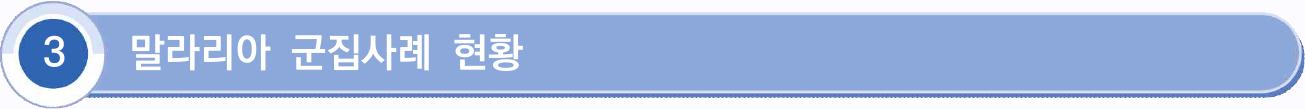

In [28]:

from IPython.display import display, HTML

def plt_img_base64(img_base64):
    # base64 이미지로 html 태그를 작성합니다
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # html 태그를 기반으로 이미지를 표기합니다
    display(HTML(image_html))

plt_img_base64(docs_by_type["images"][0])

In [29]:
docs_by_type["texts"][0]

'42주차 (10.13.~10.19.)\n\n3 말라리아 군집사례 현황\n\n* 군집사례 : 위험지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내, 환자 거주지 거리가 1Km 이내인 경우\n\n사례건수(환자수) 시·도 시군구 발생(군집사례건수) 4개 시도 46건(114명) 합계 ▸5명 군집(1) : 양천구, 강서구(1) 1건(5명) 서울 ▸2명 군집(5) : 서구(2), 강화군(1), 연수구(1), 중구(1) 인천 5건(10명) ▸6명 군집(1) : 파주시(1) ▸4명 군집(3) : 파주시(2), 김포시(1), ▸3명 군집(6) : 파주시(4), 김포시(1), 일산서구(1) 경기 39건(94명) ▸2명 군집(29) : 파주시(15), 김포시(10), 일산동구(2), 일산서구(1), 연천군(1) ▸5명 군집(1) : 철원군(1) 1건(5명) 강원\n\n그림 6. 군집사례'

In [30]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    text = f"""
    다음 문맥에만 기반하여 질문에 답하세요. 문맥에는 텍스트, 표, 그리고 아래 이미지가 포함될 수 있습니다:
    질문: {dict["question"]}

    텍스트와 표:
    {format_texts}
    """

    prompt = [
        HumanMessage(
            content=[
                {"type": "text", "text": text},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

    return prompt


model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

# RAG 파이프라인
chain = (
        {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
        | RunnableLambda(prompt_func)
        | model
        | StrOutputParser()
)

In [31]:
chain.invoke(
    "말라리아 군집 사례는 어떤가요?"
)

'42주차(10.13.~10.19.) 동안 말라리아 군집 사례는 총 46건(114명) 발생했습니다. 군집 사례는 서울, 인천, 경기, 강원 4개 시도에서 확인되었습니다. \n\n- 서울에서는 1건(5명)이 발생했습니다.\n- 인천에서는 5건(10명)이 발생했습니다.\n- 경기에서는 39건(94명)이 발생했습니다.\n- 강원에서는 1건(5명)이 발생했습니다. \n\n군집 사례는 위험 지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내이고, 환자 거주지 거리가 1Km 이내인 경우를 말합니다.'